#  Final Project 4 

# Predictive Analysis of Interest Level of Renthop Rental Listings 

## Introduction

Predict how popular an apartment rental listing is based on the listing content like text description, photos, number of bedrooms, price, etc. The data comes from renthop.com, an apartment listing website. These apartments are located in New York City. The target variable, interest_level, is defined by the number of inquiries a listing has in the duration that the listing was live on the site. 

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import googlemaps
import time
from matplotlib import pyplot as plt
plt.style.use('ggplot')
from sklearn import grid_search, cross_validation, preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_score, auc
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack
%matplotlib inline

## Helper Functions 

In [129]:
# get month from date time
def get_month(dt):
    return datetime.strptime(dt,'%Y-%m-%d %H:%M:%S').month

# request google api for neighborhood based on latitude and longitude
zip_list=[]
index_list=[]
def save_zip(df):
    for i in range(len(df)):
        d=df.iloc[i]
        try:
            res=gmaps.reverse_geocode((d['latitude'],d['longitude']))
            address=res[0]['address_components']
            for comp in address:
                if(comp['types'][0]=='neighborhood'):
                    zip_list.append(str(comp['long_name']))
                    index_list.append(df.index[i])
        except:
            pass
        if((i>1)and((i % 10)==0)):
            time.sleep(0.22)
            data2save=pd.DataFrame({'neighborhood':zip_list},index=index_list)
            data2save.to_csv('test_zip_.csv')

## Explanatory Analysis

In [123]:
# load train data
train=pd.read_json('train.json')

In [97]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49352 entries, 10 to 99994
Data columns (total 15 columns):
bathrooms          49352 non-null float64
bedrooms           49352 non-null int64
building_id        49352 non-null object
created            49352 non-null object
description        49352 non-null object
display_address    49352 non-null object
features           49352 non-null object
interest_level     49352 non-null object
latitude           49352 non-null float64
listing_id         49352 non-null int64
longitude          49352 non-null float64
manager_id         49352 non-null object
photos             49352 non-null object
price              49352 non-null int64
street_address     49352 non-null object
dtypes: float64(3), int64(3), object(9)
memory usage: 6.0+ MB


In [98]:
train.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,6888711,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.8241,6934781,-73.9493,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street


The data is in a good shape. No nulls. Also column building_id, listing_id, manager_id should be dropped. We will use latitude and longitude for location infromation. So display_address and street_address can be removed too. 

In [124]:
train=train.drop(['building_id', 'listing_id', 'manager_id','display_address','street_address'], 1)

Replace interest level with numbers

In [125]:
train=train.replace({"interest_level": {"low": 0, "medium": 1, "high": 2}})

In [106]:
train.interest_level.value_counts()

0    34284
1    11229
2     3839
Name: interest_level, dtype: int64

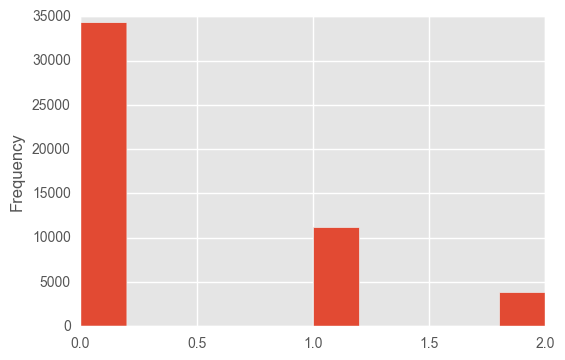

In [107]:
train['interest_level'].plot.hist();

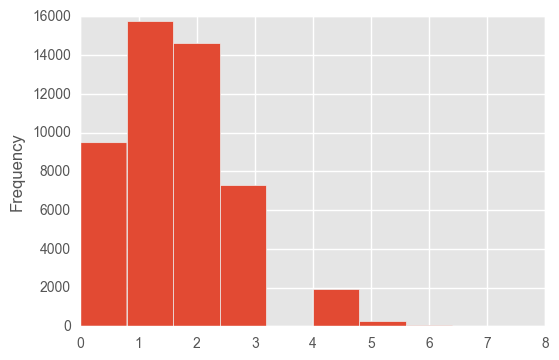

In [108]:
train['bedrooms'].plot.hist();

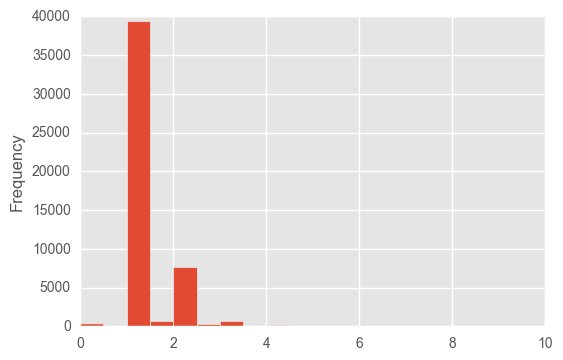

In [109]:
train['bathrooms'].plot.hist(bins=20);

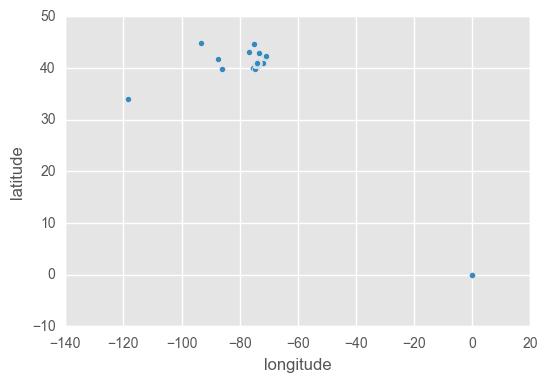

In [110]:
train[['latitude','longitude']].plot.scatter(x='longitude',y='latitude');

Need to remove bad latitude and bad longitude. From the graph, we can see there are outliners. To exclude the outliners, we can get the latitude and longitude ranges by clicking on Google Map. Latitude=[40.496217,40.910596], longitude=[-75.255653,-73.701978]. Loose the numbers 0.5 to exlude outliners.

In [126]:
train=train[(train.longitude>-75.30)|(train.longitude<-73.75)|(train.latitude>40.45)|(train.latitude<40.95)]

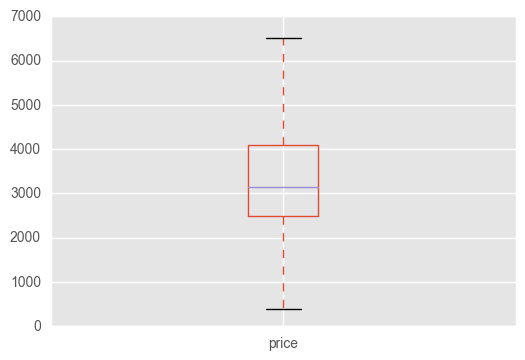

In [112]:
train['price'].plot(kind='box',ylim=[0,7000]);

In [113]:
train[train.price>100000]

,bathrooms,bedrooms,created,description,features,interest_level,latitude,longitude,photos,price
12168,1.0,2,2016-06-24 05:02:58,,"[Doorman, Elevator, Cats Allowed, Dogs Allowed...",0,40.8011,-73.9480,[],1150000
123877,0.0,0,2016-04-12 02:11:10,"Originally built in 1862, this extraordinary l...","[Elevator, Pre-War, Terrace, Dogs Allowed, Cat...",0,40.7161,-74.0080,[https://photos.renthop.com/2/6857401_a4a4c2f2...,135000
32611,1.0,2,2016-06-24 05:02:11,,"[Doorman, Elevator, Cats Allowed, Dogs Allowed...",0,40.7299,-74.0071,[],4490000
4620,1.0,0,2016-06-07 17:35:10,The BEST DEAL!!!!!\r\rBeautiful Studio in a ni...,"[Elevator, Laundry In Building, Balcony]",2,40.7323,-73.8761,[https://photos.renthop.com/2/7122037_531f0877...,111111
55437,1.0,1,2016-05-14 05:21:28,,"[Doorman, Cats Allowed, Dogs Allowed]",0,40.7676,-73.9844,[],1070000
57803,1.0,1,2016-05-19 02:37:06,This 1 Bedroom apartment is located on a prime...,"[Doorman, Elevator, Pre-War, Dogs Allowed, Cat...",0,40.7676,-73.9844,[https://photos.renthop.com/2/7036279_924b52f0...,1070000


In [127]:
train=train[train.price<=100000]
train.head()

,bathrooms,bedrooms,created,description,features,interest_level,latitude,longitude,photos,price
10,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,[],1,40.7145,-73.9425,[https://photos.renthop.com/2/7211212_1ed4542e...,3000
10000,1.0,2,2016-06-12 12:19:27,,"[Doorman, Elevator, Fitness Center, Cats Allow...",0,40.7947,-73.9667,[https://photos.renthop.com/2/7150865_be3306c5...,5465
100004,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...","[Laundry In Building, Dishwasher, Hardwood Flo...",2,40.7388,-74.0018,[https://photos.renthop.com/2/6887163_de85c427...,2850
100007,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,"[Hardwood Floors, No Fee]",0,40.7539,-73.9677,[https://photos.renthop.com/2/6888711_6e660cee...,3275
100013,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,[Pre-War],0,40.8241,-73.9493,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350


In [ ]:
Lower prices, more interests

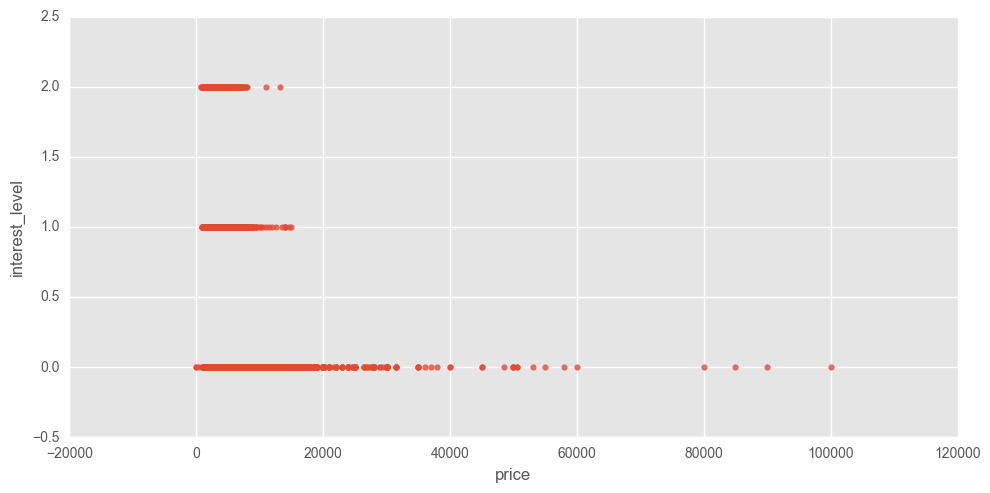

In [135]:
sns.lmplot('price', 'interest_level', 
           data=train, size=5, aspect=2,
           fit_reg=False, 
           line_kws={'linestyle':'-', 'linewidth':'1'});

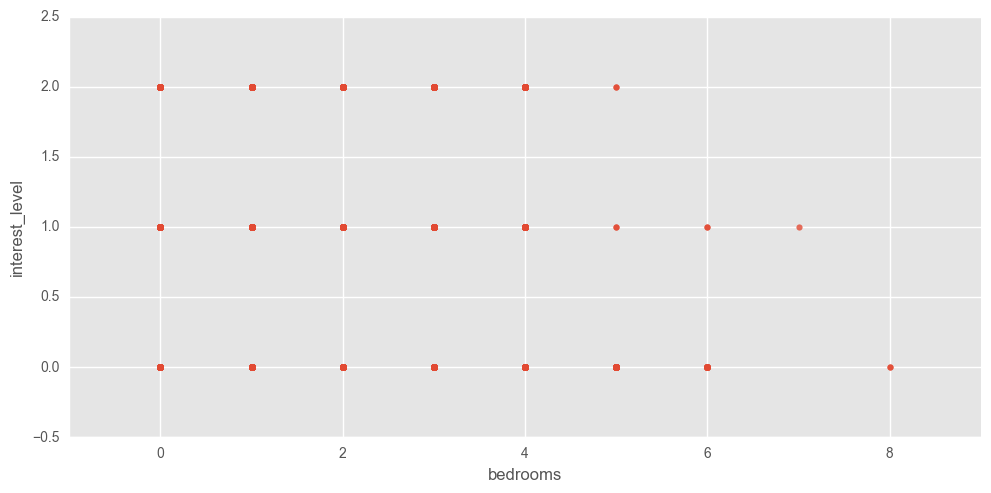

In [136]:
sns.lmplot('bedrooms', 'interest_level', 
           data=train, size=5, aspect=2,
           fit_reg=False, 
           line_kws={'linestyle':'-', 'linewidth':'1'});

## Feather Engineering 

### created  

In [ ]:
Extract month code from date time. To model seasonality.

In [130]:
train['created']=train['created'].apply(get_month)

### Description and Features

Better descriptions and more features attract attentions. So there are some informationt to attract. For simpilicty, we will use the word counts for these two columns

In [131]:
train['description']=train.description.apply(len)
train['features']=train.features.apply(len)

### Photos 

In [ ]:
Photos attracts attentions too. For simpilitcy, we use the photo counts for modeling

In [132]:
train['photos']=train.photos.apply(len)

### Latitude and Longitude to neighborhood

In [ ]:
#save_zip(train)

In [133]:
train_zip=pd.read_csv('train_zip_.csv', index_col=0)
train_zip.head()

,neighborhood
10,Williamsburg
10000,Upper West Side
100004,Lower Manhattan
100007,Midtown East
100013,Upper Manhattan


In [134]:
train=train.join(train_zip)
train=train.dropna()
train.head()

,bathrooms,bedrooms,created,description,features,interest_level,latitude,longitude,photos,price,neighborhood
10,1.5,3,6,588,0,1,40.7145,-73.9425,5,3000,Williamsburg
10000,1.0,2,6,8,5,0,40.7947,-73.9667,11,5465,Upper West Side
100004,1.0,1,4,691,4,2,40.7388,-74.0018,8,2850,Lower Manhattan
100007,1.0,1,4,492,2,0,40.7539,-73.9677,3,3275,Midtown East
100013,1.0,4,4,479,1,0,40.8241,-73.9493,3,3350,Upper Manhattan


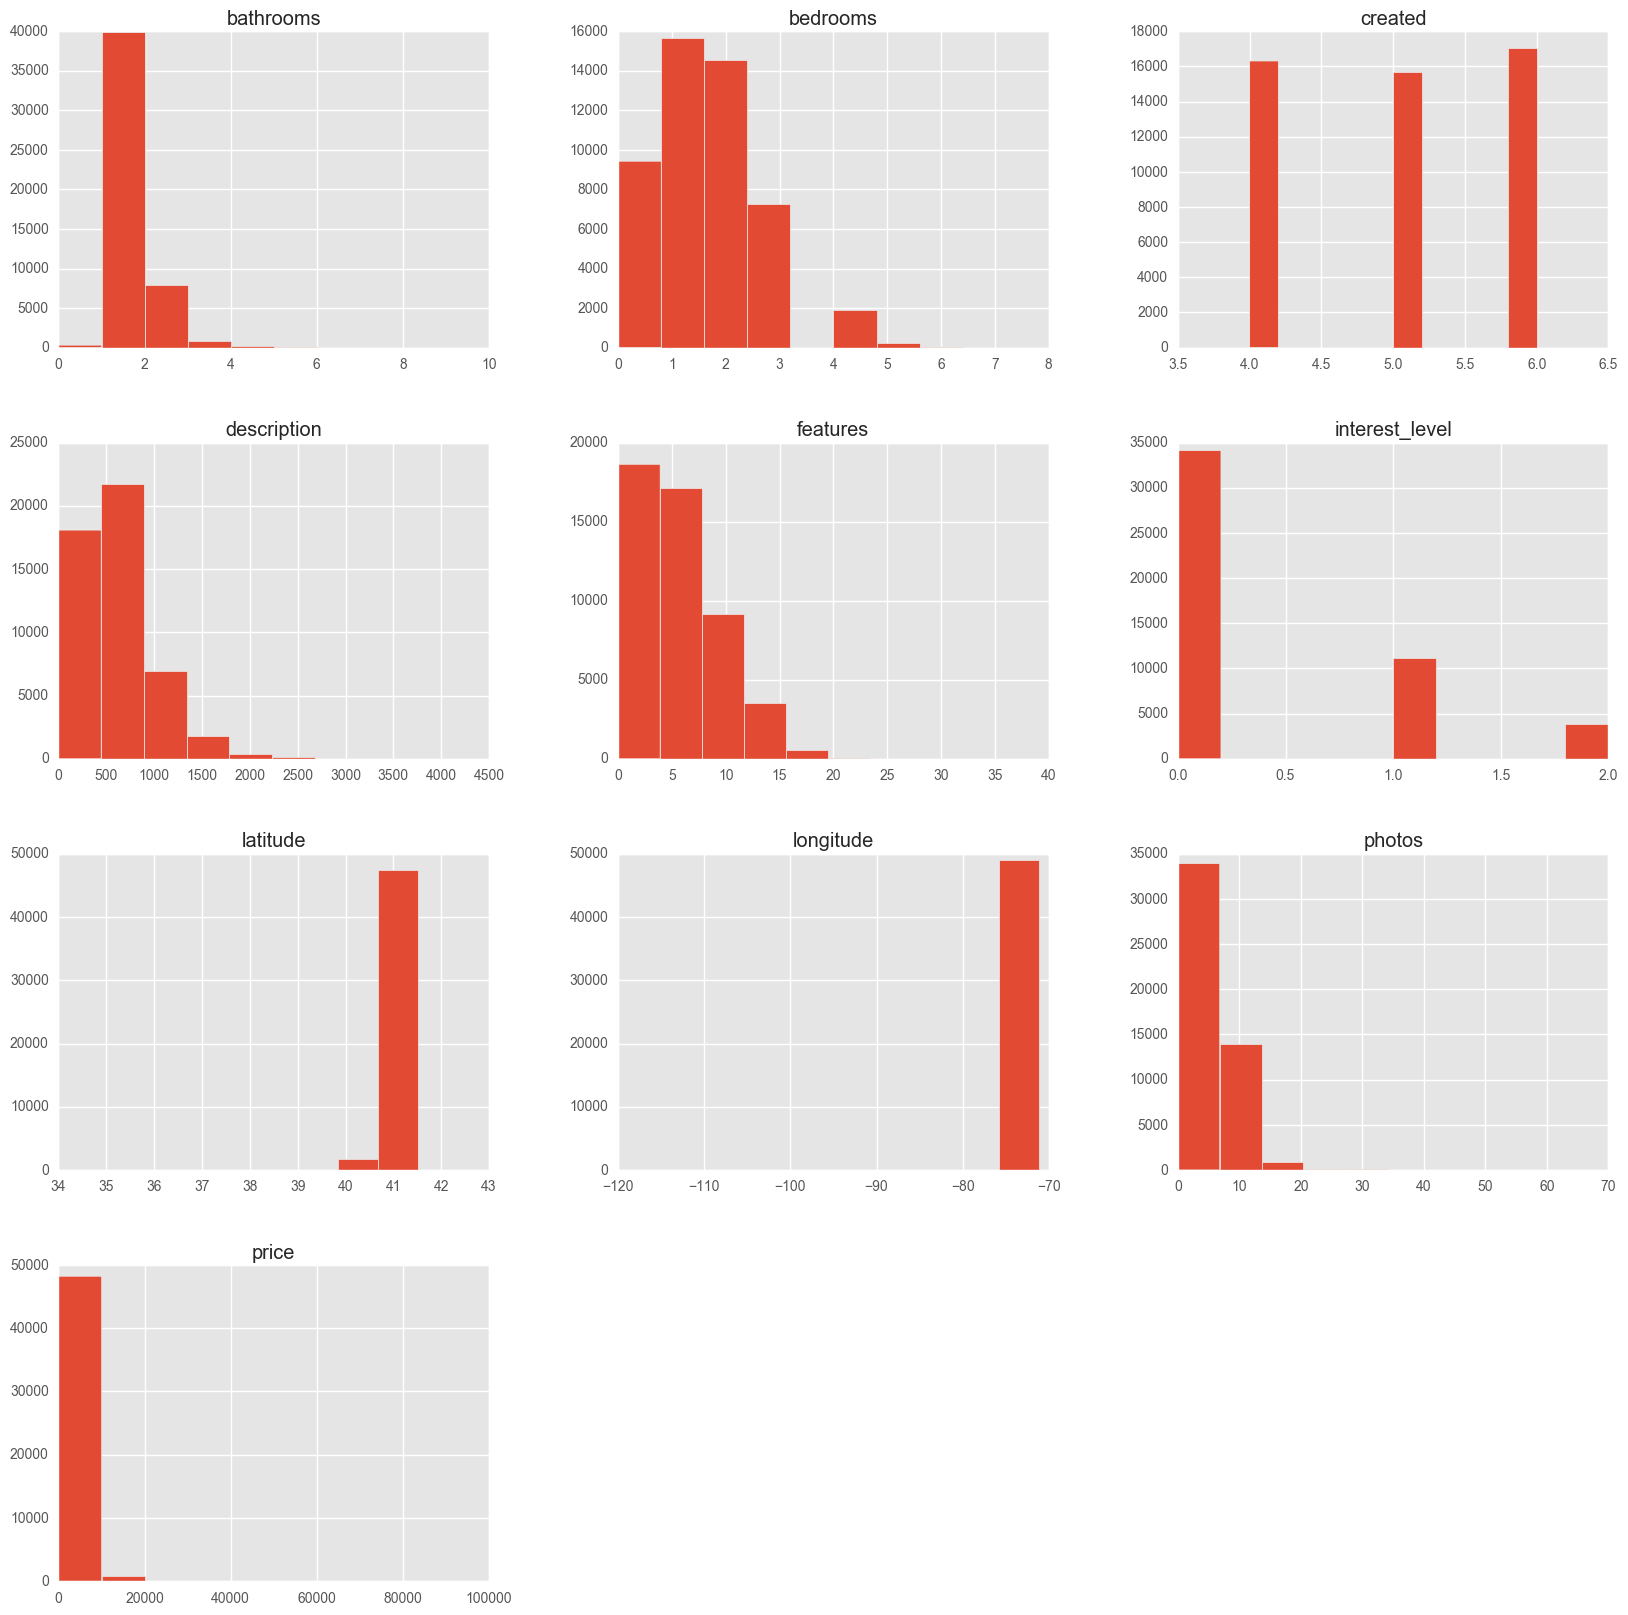

In [137]:
train.hist(figsize=(20,20));

## Modeling 

### Correlation 
Before modeling logistic regression, test the correlation of variables and predictor. 

In [8]:
train.corr()

,bathrooms,bedrooms,created,description,features,interest_level,photos,price
bathrooms,1.000000,0.532360,0.000902,0.148351,0.229466,-0.081860,0.145906,0.665409
bedrooms,0.532360,1.000000,0.015097,0.111039,0.129541,0.028156,0.154058,0.464214
created,0.000902,0.015097,1.000000,-0.019399,-0.010759,-0.005026,0.008616,0.005665
description,0.148351,0.111039,-0.019399,1.000000,0.437221,0.052039,0.211149,0.154109
features,0.229466,0.129541,-0.010759,0.437221,1.000000,0.024782,0.157845,0.232796
interest_level,-0.081860,0.028156,-0.005026,0.052039,0.024782,1.000000,0.029675,-0.178716
photos,0.145906,0.154058,0.008616,0.211149,0.157845,0.029675,1.000000,0.120692
price,0.665409,0.464214,0.005665,0.154109,0.232796,-0.178716,0.120692,1.000000


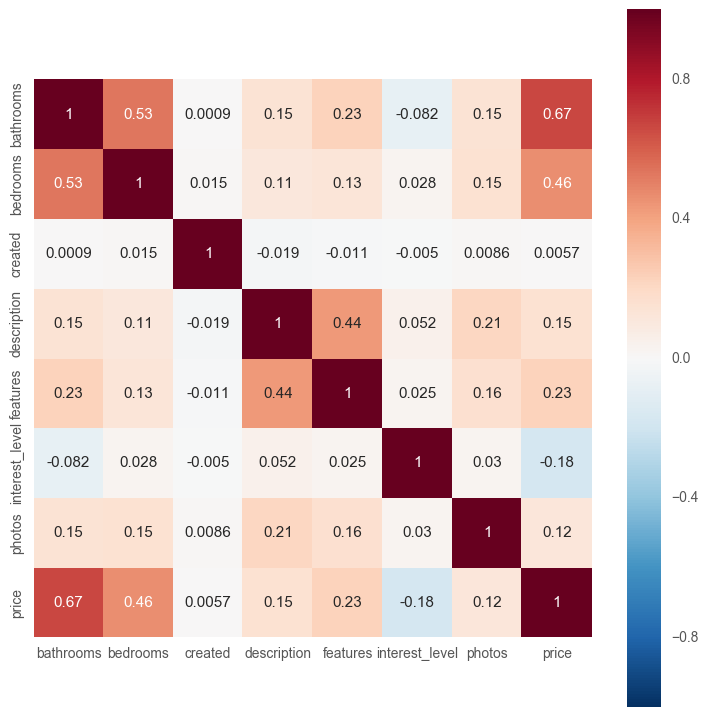

In [20]:
plt.figure(figsize=(9,9))
sns.heatmap(train.corr(), square=True, annot=True, annot_kws={'size': 11});

Notice bathroom and price, bathroom and bedroom, bedroom and price have pretty high correlation. But not enough to remove one of them yet. Also notice price is negatively correlated to interest_level. 

### Dummy Variables 

Set created and neighborhood to dummy variables

In [41]:
train=pd.get_dummies(train,columns=['created'],drop_first='True')

In [42]:
train=pd.get_dummies(train,columns=['neighborhood'],prefix='nh',drop_first='True')

In [40]:
train.head()

,bathrooms,bedrooms,created,description,features,interest_level,photos,price,neighborhood
10,1.5,3,6,588,0,1,5,3000,Williamsburg
10000,1.0,2,6,8,5,0,11,5465,Upper West Side
100004,1.0,1,4,691,4,2,8,2850,Lower Manhattan
100007,1.0,1,4,492,2,0,3,3275,Midtown East
100013,1.0,4,4,479,1,0,3,3350,Upper Manhattan


In [92]:
features_set=list(train.columns)
features_set.remove('interest_level')

### Logistic Regression 

In [125]:
lm=LogisticRegression()
lm=lm.fit(train.drop(['interest_level'],1),train.interest_level)

In [131]:
# cross_validate not working with multiclass
scores={}
for i in range(-5,5):
    c=10**-i
    lm=LogisticRegression(C=c)
    lm.fit(train.drop(['interest_level'],1),train.interest_level)
    scores[c]=np.mean(cross_validation.cross_val_score(lm, train[features_set], train.interest_level, cv=5))

In [132]:
# scores is the default score function for the model. In this case(logstic regression), it is mean accuracy 
scores

{0.0001: 0.69287504272662459,
 0.001: 0.69098010038103819,
 0.01: 0.691856285355682,
 0.1: 0.69316030790880134,
 1: 0.69340471951018468,
 10: 0.69385303784679919,
 100: 0.6941790196147315,
 1000: 0.69373079260814219,
 10000: 0.69350665004529399,
 100000: 0.6930583524655034}

In [136]:
c=max(scores, key=scores.get) # get the C for the maximum accuracy 100
lm=LogisticRegression(C=100)
lm=lm.fit(train.drop(['interest_level'],1),train.interest_level)

In [141]:
y_pred = lm.predict(train[features_set])
confusion = confusion_matrix(y_true=train.interest_level, y_pred=y_pred)
confusion

array([[32999,  1092,     9],
       [10221,   938,     4],
       [ 3212,   560,    46]])

In [145]:
precision_score(y_true=train.interest_level, y_pred=y_pred, average='weighted')

0.63678956514218088

In [ ]:
The outputs of logistic regress are not satisfying, especially the predict on interest leve 1 and 2(medium and high)

### Random Forest Tree

In [84]:
X=train.drop(['interest_level'],1)
y=train.interest_level

In [180]:
auc_scores = {}
for n_trees in range(120, 160, 5):
    model = RandomForestClassifier(n_estimators = n_trees)
    scores = cross_validation.cross_val_score(model, X, y)  #auc score not supported for multiclass
    print('n trees: {}, CV mean accuracy {}, Average mean accuracy {}'.format(n_trees, scores, scores.mean()))
    auc_scores[n_trees] = scores.mean()

n trees: 120, CV mean accuracy [ 0.71028666  0.7104089   0.70884528], Average mean accuracy 0.709846946816
n trees: 125, CV mean accuracy [ 0.71095899  0.7107145   0.70921205], Average mean accuracy 0.710295182122
n trees: 130, CV mean accuracy [ 0.71065338  0.71102011  0.70817287], Average mean accuracy 0.709948787681
n trees: 135, CV mean accuracy [ 0.71199804  0.7118758   0.70982334], Average mean accuracy 0.711232395059
n trees: 140, CV mean accuracy [ 0.71053114  0.71199804  0.71110704], Average mean accuracy 0.711212073713
n trees: 145, CV mean accuracy [ 0.71095899  0.71053114  0.70988447], Average mean accuracy 0.710458198744
n trees: 150, CV mean accuracy [ 0.71034778  0.7104089   0.71055688], Average mean accuracy 0.71043785249
n trees: 155, CV mean accuracy [ 0.70918648  0.71089787  0.70976221], Average mean accuracy 0.709948852442


In [86]:
model = RandomForestClassifier(n_estimators = 135)
model.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=135, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [190]:
y_pred = model.predict(train[features_set])

In [192]:
confusion = confusion_matrix(y_true=train.interest_level, y_pred=y_pred)
confusion

array([[33921,   168,    11],
       [  311, 10783,    69],
       [   35,   113,  3670]])

In [193]:
precision_score(y_true=train.interest_level, y_pred=y_pred, average='weighted')

0.98554881096827218

In [ ]:
The outputs are much better than logistic regression.

In [95]:
feature_importances = pd.DataFrame({'Features' : features_set, 'Importance Score': model.feature_importances_})
feature_importances.sort_values('Importance Score', ascending=False).head(5)

,Features,Importance Score
5,price,0.274548
2,description,0.249697
4,photos,0.134178
3,features,0.128284
1,bedrooms,0.052511


### Random Forest Tree with countVectorizer

In [6]:
train2=pd.read_csv('train_ready.csv',index_col=0,usecols=[0,1,2,3,6,9,10,11])

In [7]:
train2=pd.get_dummies(train2,columns=['created'],drop_first='True')

In [8]:
train2=pd.get_dummies(train2,columns=['neighborhood'],prefix='nh',drop_first='True')

In [9]:
raw=pd.read_json('train.json')
raw=raw[['description','features']]
raw['features']=raw.features.apply(str)
train3=train2.join(raw)

In [67]:
vectorizer1 = CountVectorizer(max_features = 1000, 
                             ngram_range=(1, 2), 
                             stop_words='english',
                             binary=True)
features=vectorizer1.fit_transform(train3['features'])

In [69]:
vectorizer2 = CountVectorizer(max_features = 1000, 
                             ngram_range=(1, 1), 
                             stop_words='english',
                             binary=True)
description=vectorizer2.fit_transform(train3['description'])

In [71]:
X = hstack((description,features, train2.drop(['interest_level'],1))).toarray()

In [72]:
y=train2.interest_level

In [73]:
auc_scores = {}
for n_trees in range(120, 176, 15):
    model = RandomForestClassifier(n_estimators = n_trees)
    scores = cross_validation.cross_val_score(model, X, y)  #auc score not supported for multiclass
    print('n trees: {}, CV mean accuracy {}, Average mean accuracy {}'.format(n_trees, scores, scores.mean()))
    auc_scores[n_trees] = scores.mean()

n trees: 120, CV mean accuracy [ 0.71346495  0.71529858  0.71251299], Average mean accuracy 0.713758837601
n trees: 135, CV mean accuracy [ 0.71322046  0.71456512  0.7127575 ], Average mean accuracy 0.713514363731
n trees: 150, CV mean accuracy [ 0.71267037  0.71474849  0.71147381], Average mean accuracy 0.712964222798
n trees: 165, CV mean accuracy [ 0.71413728  0.71468737  0.71281863], Average mean accuracy 0.713881091972


In [74]:
model2 = RandomForestClassifier(n_estimators = 165)
model2.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=165, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [75]:
y_pred = model2.predict(X)
confusion = confusion_matrix(y_true=train.interest_level, y_pred=y_pred)
confusion

array([[33898,   181,    21],
       [  304, 10783,    76],
       [   25,   115,  3678]])

In [76]:
precision_score(y_true=train.interest_level, y_pred=y_pred, average='weighted')

0.98524625852884817

In [54]:
features_set2=features_set
features_set2.remove('features')
features_set2.remove('description')

In [79]:
all_feature_names = vectorizer2.get_feature_names()+vectorizer1.get_feature_names() + features_set2
feature_importances = pd.DataFrame({'Features' : all_feature_names, 'Importance Score': model2.feature_importances_})
feature_importances.sort_values('Importance Score', ascending=False).head(10)

,Features,Importance Score
2003,price,0.057197
2002,photos,0.022693
2004,created_5,0.019065
2005,created_6,0.018300
2001,bedrooms,0.014267
1406,fee,0.005790
2000,bathrooms,0.005614
130,bedroom,0.003648
1321,doorman,0.003631
1360,elevator,0.003356


##  Conclusion

With information on bedrooms, bathrooms, created time, description, features, price, number of photos, and geolocation of a listing, Random Forest Tree model predicts the interest level very well.